## ML notebook
This notebook is used for creating dataset, preprocessing data and building the ML models

In [13]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import sys
sys.path.append("../src")

In [ ]:
# This cell is for building the dataset. Uncomment the line below for use
# !python "../src/build_dataset.py"

In [3]:
df = pd.read_csv("../ml_dataset.csv")
df

,systolic_amp_mean,systolic_amp_std,diastolic_amp_mean,diastolic_amp_std,notch_amp_mean,notch_amp_std,pulse_width_mean,pulse_width_std,rise_time_mean,rise_time_std,heart_rate_mean,heart_rate_std,spo2_ref,activity,gender,age,height,weight
0,238.720288,94.500352,64.567068,75.069381,-265.279586,101.628429,0.367585,0.053439,0.183826,0.032330,101.261865,11.340650,96.5,run,female,25,160,60
1,322.748649,106.003345,-104.210957,40.286477,-330.125603,128.519489,0.338405,0.015522,0.187396,0.011268,75.106689,6.163541,96.5,sit,female,25,160,60
2,48.134281,25.546114,12.066301,19.563100,-63.577112,31.585656,0.423378,0.156871,0.357946,0.195382,80.988035,15.543122,96.0,walk,female,25,160,60
3,178.008777,95.563618,46.505269,85.444858,-188.921948,83.845574,0.458612,0.159749,0.364126,0.173545,83.756649,19.065600,97.0,run,male,30,180,65
4,61.259879,25.154081,-26.243015,15.526599,-43.659347,17.499206,0.328015,0.069477,0.235265,0.091978,73.398603,8.238628,97.5,sit,male,30,180,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,164.802472,111.574905,33.592604,115.885382,-161.235340,124.966950,0.413355,0.122867,0.281997,0.142941,84.461473,11.134728,97.0,sit,male,50,175,75
62,53.276537,52.992606,14.250452,43.762962,-58.077982,62.542345,0.526237,0.179503,0.443688,0.125108,86.620858,14.879769,97.5,walk,male,50,175,75
63,21.099351,11.513602,7.189939,9.398736,-22.718245,12.444508,0.457829,0.160050,0.357807,0.182052,81.761211,18.267654,98.0,run,male,20,175,70
64,23.925645,8.120279,-1.808616,7.990671,-19.359263,6.062872,0.390175,0.153305,0.267378,0.125700,72.553837,13.806977,98.5,sit,male,20,175,70


## Pre-processing and checking the performance of baseline models

In [4]:
# Target feature
y = df["spo2_ref"]

# Features
X = df.drop(columns=["spo2_ref"])

In [5]:
# Define categorical and numerical columns
cat_cols = ["activity", "gender"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

In [6]:
# Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Testing out baseline models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "SVM": SVR(kernel="rbf", C=10, epsilon=0.1)
}

# Adding cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# Preprocessing and fitting the data to the models
cross_val_results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    # MAE and MSE (negative sign because scoring function is negative)
    mae_scores = -cross_val_score(pipe, X_train, y_train, cv=cv,
                                  scoring="neg_mean_absolute_error")
    mse_scores = -cross_val_score(pipe, X_train, y_train, cv=cv,
                                  scoring="neg_mean_squared_error")
    rmse_scores = -cross_val_score(pipe, X_train, y_train, cv=cv,
                                  scoring="neg_root_mean_squared_error")
    
    cross_val_results[name] = {
        "MAE_mean": mae_scores.mean(),
        "MAE_std": mae_scores.std(),
        "MSE_mean": mse_scores.mean(),
        "MSE_std": mse_scores.std(),
        "RMSE_mean": rmse_scores.mean(),
        "RMSE_std": rmse_scores.std()
    }

Calculating `mean` for checking **average model performance** across the 5 folds and `standard deviation` for checking **model stability**.

In [14]:
cross_val_results

{'Linear Regression': {'MAE_mean': 1.0062187516977412,
  'MAE_std': 0.3289174572357839,
  'MSE_mean': 1.6318448931697271,
  'MSE_std': 0.9426295199514313,
  'RMSE_mean': 1.2238885927971122,
  'RMSE_std': 0.365980334978304,
  'R2_mean': -2.0743203216989707,
  'R2_std': 1.8861929207324135},
 'Random Forest': {'MAE_mean': 0.6344136363636366,
  'MAE_std': 0.11530788322523366,
  'MSE_mean': 0.6986190340909089,
  'MSE_std': 0.2083167709963525,
  'RMSE_mean': 0.8254571267618113,
  'RMSE_std': 0.13129952768020084,
  'R2_mean': -0.35267599401195376,
  'R2_std': 0.5903219329071461},
 'SVM': {'MAE_mean': 0.6668028464318694,
  'MAE_std': 0.17129651198867987,
  'MSE_mean': 0.7691523059662274,
  'MSE_std': 0.3163911709305851,
  'RMSE_mean': 0.8594453961793498,
  'RMSE_std': 0.17465943132950984,
  'R2_mean': -0.5180539521713656,
  'R2_std': 0.7912478787512327}}

## Random Forest Regressor: Hyperparameter Tuning
The cross validation scores indicate that baseline Random Forest Regressor is performing better in terms of both mean and standard deviation across all loss functions.

Therefore, tuning the hyperparameters of the Random Forest Regressor model to find its optimal parameters for the best results.

In [7]:
# Defining pipeline
pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42))
    ])

# Grid search setup
param_grid = {
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

# Fitting data to the model
grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['systolic_amp_mean',
                                                                          'systolic_amp_std',
                                                                          'diastolic_amp_mean',
                                                                          'diastolic_amp_std',
                                                                          'notch_amp_mean',
                                                                          'notch_amp_std',
                                                                          'pulse_width_mean',
                                                                          'pulse_width_std',
                                                                          'rise_time_mean',
                                                                          'rise_time_std',
                                                                          'hear...
                                                                         OneHotEncoder(drop='first'),
                                                                         ['activity',
                                                                          'gender'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 5, 10, 20],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 500]},
             scoring='neg_mean_absolute_error', verbose=2)

In [11]:
best_model = grid.best_estimator_
best_params = grid.best_params_
best_scores = grid.best_score_
print(f"Best Model: {best_model}\nBest Params: {best_params}\nBest Scores: {-best_scores}")

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['systolic_amp_mean',
                                                   'systolic_amp_std',
                                                   'diastolic_amp_mean',
                                                   'diastolic_amp_std',
                                                   'notch_amp_mean',
                                                   'notch_amp_std',
                                                   'pulse_width_mean',
                                                   'pulse_width_std',
                                                   'rise_time_mean',
                                                   'rise_time_std',
                                                   'heart_rate_mean',
                                                   'heart_rate_std', 'age',
                               

---
As indicated above, these are the best model params for Random Forest Regressor:

**'model__max_depth': None**,

**'model__max_features': 'sqrt'**, 

**'model__min_samples_leaf': 1**, 

**'model__min_samples_split': 2**, 

**'model__n_estimators': 500**


## Evaluating model performance

In [14]:
# Checking out the model predictions on the holdout test set
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}")

MAE: 0.8031428571428562
MSE: 1.0545897142857117
RMSE: 1.0269321858261682


In [22]:
tested_df = pd.DataFrame()
tested_df["Actual SpO2"] = y_test
tested_df["Predicted SpO2"] = y_pred
tested_df

,Actual SpO2,Predicted SpO2
54,97.0,96.819
62,97.5,97.340
0,96.5,96.533
45,94.5,97.195
5,98.0,97.083
63,98.0,97.244
16,98.5,97.496
12,96.5,97.186
65,98.5,97.667
30,98.5,97.036


In [26]:
tested_df.to_csv("../rf_predictions.csv")

## Saving the best model

In [24]:
import pickle

# Saving the best model
with open("../best_rf_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [ ]:
# Loading the best model and predicting the test data (Uncomment below to perform the action)
# with open("../best_rf_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

# y_pred_new = loaded_model.predict(X_test)

## Feature Importances

               feature  importance
13              height    0.100906
5        notch_amp_std    0.083845
4       notch_amp_mean    0.074481
10     heart_rate_mean    0.073924
6     pulse_width_mean    0.068216
1     systolic_amp_std    0.066340
2   diastolic_amp_mean    0.063696
8       rise_time_mean    0.062270
0    systolic_amp_mean    0.059259
9        rise_time_std    0.059113
3    diastolic_amp_std    0.058017
12                 age    0.055453
7      pulse_width_std    0.053120
14              weight    0.052740
11      heart_rate_std    0.041126
17         gender_male    0.011602
16       activity_walk    0.010624
15        activity_sit    0.005267


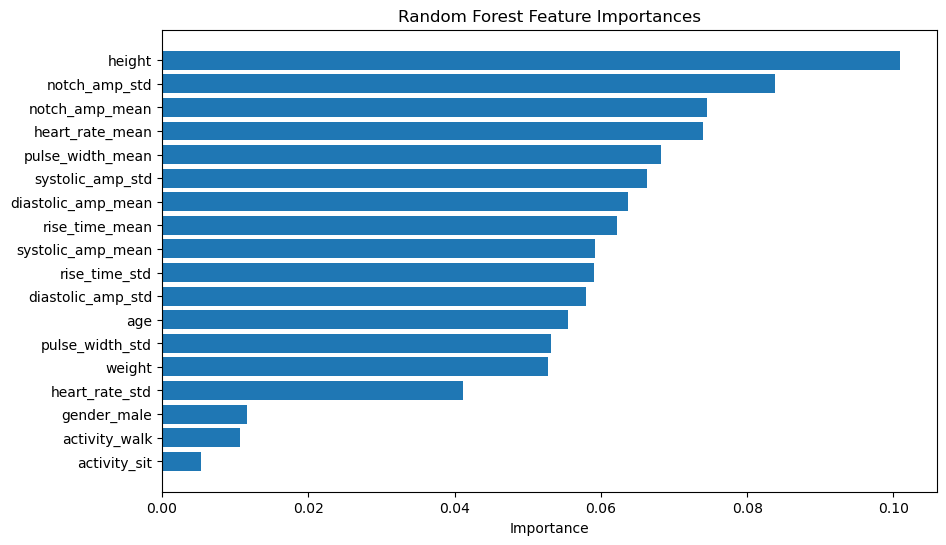

In [27]:
# Get the trained RF model from pipeline
rf_model = best_model.named_steps["model"]

# Get feature names after preprocessing
ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(["activity", "gender"])
num_feature_names = num_cols 
all_features = np.concatenate([num_feature_names, cat_feature_names])

# Match feature importances
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp)

# Optional: Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"], feat_imp["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

**Height** has a significant importance `~10%` in predicting SpO2 values by the Random Forest Regressor model. This might be due to the smaller dataset trained with.

The other **PPG features** have around `6% - 8%` importances each, indicating the model mostly learnt through PPG signals.

Although more data would have resulted in a better model.